In [109]:
import os
from collections import defaultdict
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import rbo
import numpy as np


def get_result_of_run(pool_path, run_path, metrics_to_eval, model_name):

    res = (os.popen(" .trec_eval -c -q -m ndcg_cut.3,5 -m recall -m ndcg -m official {pool_path}  {run_path}".format(pool_path=pool_path, run_path=run_path)).read())
    lines = (res.strip().split('\n'))
    res_dict = defaultdict(lambda: defaultdict(str))

    for line in lines:
        line = line.replace(' ', '')
        metric, turn, value = line.split('\t')
        res_dict[turn][metric] = value

    str_out = model_name
    for i in range(0, len(metrics_to_eval)):
            str_out += ' & '+res_dict['all'][metrics_to_eval[i]]

    str_out += ' \\\\'

    # print(str_out)
    return str_out, res_dict['all']

def eval_all_models_given_pool(pool_path, directory_name, metrics_to_eval):

    model_names = os.listdir(directory_name)
    results_per_model = {}

    for i in range(0, len(model_names)):
        model_name = model_names[i]
        if model_name.endswith('run'):
            run_path = 'trec_format/{modelName}'.format(modelName=model_name)
            table_row, res = get_result_of_run(pool_path, run_path, metrics_to_eval, model_name)
            results_per_model[model_name] = res

    return results_per_model        

def return_sorted_list_of_runs(results_per_model, metric_to_compare):
    tmp_dict = {}
    for model_name in results_per_model:
        tmp_dict[model_name] = results_per_model[model_name][metric_to_compare]
    sorted_list_of_runs = [k for k, v in sorted(tmp_dict.items(), key=lambda item: item[1], reverse=True)]

    return sorted_list_of_runs

def compare_two_lists(sorted_list_1, sorted_list_2):
    corr_kendall, _ = kendalltau(sorted_list_1, sorted_list_2)
    
    corr_spearman, _ = spearmanr(sorted_list_1, sorted_list_2)

    return corr_kendall, corr_spearman

def compare_two_lists_at_k(pred_list, reference_list, k):

    list_1 = reference_list[0:k]
    list_2 = [run for run in pred_list if run in list_1]

    
    dict_run_name_index = {}
    for i in range(0, len(list_1)):
        dict_run_name_index[list_1[i]] = i

    list_1_idx = [dict_run_name_index[run] for run in list_1]
    list_2_idx = [dict_run_name_index[run] for run in list_2]
    print(list_1_idx)
    print(list_2_idx)

    corr_kendall, _ = kendalltau(list_1_idx, list_2_idx)

    
    corr_spearman, _ = spearmanr(list_1_idx, list_2_idx)

    rbo_ = rbo.RankingSimilarity(list_1_idx, list_2_idx).rbo()

    return corr_kendall, corr_spearman, rbo_

def ranking_level_eval_one_model(pool_path, pool_path_2, directory_name, metrics_to_eval):
    results_per_model_1 = eval_all_models_given_pool(pool_path, directory_name, metrics_to_eval)
    results_per_model_2 = eval_all_models_given_pool(pool_path_2, directory_name, metrics_to_eval)

    line = """Ranking metric & K=2 & K=4 + K=6 & K=8 &  K=10 &  K=12 +  K=14 +  K=16 &  K=18 &  K=20 & K=22 & K=24 &  K=26 &  K=28 \\\\ \ toprule"""
    print(line)
    print()
    lines_spearman = [line]
    lines_kendall  = [line]
    lines_rbo      = [line]

    for metric in metrics_to_eval:

        sorted_list_1 = return_sorted_list_of_runs(results_per_model_1, metric)
        sorted_list_2 = return_sorted_list_of_runs(results_per_model_2, metric)

        line_kande = metric + ' & '
        line_spear = metric + ' & '
        line_rbo = metric + ' & ' 

        for k_ in range(2, len(sorted_list_1)+1):
            k, s, rbo_ = compare_two_lists_at_k(sorted_list_1, sorted_list_2, k_)
            if k_==len(sorted_list_1):
                line_kande += str("{:.3f}".format(k)) + ' \\\\ \midrule'
                line_spear += str("{:.3f}".format(s)) + ' \\\\ \midrule'
                line_rbo   += str("{:.3f}".format(rbo_)) + ' \\\\ \midrule'
            
            else:
                line_kande += str("{:.3f}".format(k)) + ' & '
                line_spear += str("{:.3f}".format(s))  + ' & '
                line_rbo   += str("{:.3f}".format(rbo_)) + ' & '

        lines_spearman.append(line_spear)
        lines_kendall.append(line_kande)
        lines_rbo.append(line_rbo)

    return lines_spearman, lines_kendall, lines_rbo
  
def ranking_level_eval(all_models_names, directory_name, metrics_to_eval, pool_directory):

    header_line = "Metric & Hole Filling Model "
    for metric in metrics_to_eval:
        header_line += ' & ' + metric.replace('_', '\_')
    header_line +=  " \\\\ \\toprule"
    print(header_line)
    a_list = []
    b_list = []
    c_list = []
    pool_path_2 = 'tmp_pools/human_qrels_tab.txt'
    
    for model_index in range(0, len(all_models_names)) :
        model_name = all_models_names[model_index]
        pool_path = pool_directory + model_name+'.txt'
        
        results_per_model_1 = eval_all_models_given_pool(pool_path, directory_name, metrics_to_eval)
        results_per_model_2 = eval_all_models_given_pool(pool_path_2, directory_name, metrics_to_eval)
        
        if model_index == 0:
            line_kande =  '$\\tau$  & ' + models_main_name[model_name]
            line_spear =  '$\\rho$  & ' + models_main_name[model_name]
            line_rbo   =  'RBO     & ' + models_main_name[model_name]
        else:
            line_kande =  ' & ' + models_main_name[model_name]
            line_spear =  ' & ' + models_main_name[model_name]
            line_rbo   =  ' & ' + models_main_name[model_name]
        
        for metric in metrics_to_eval:
            sorted_list_1 = return_sorted_list_of_runs(results_per_model_1, metric)
            sorted_list_2 = return_sorted_list_of_runs(results_per_model_2, metric)

            k_ = len(sorted_list_1)
            k, s, rbo_ = compare_two_lists_at_k(sorted_list_1, sorted_list_2, k_)
            line_kande +=  ' & ' + str("{:.3f}".format(k)) 
            line_spear +=  ' & ' + str("{:.3f}".format(s)) 
            line_rbo   +=  ' & ' + str("{:.3f}".format(rbo_)) 

        line_kande += ' \\\\ \cmidrule{2-10}'
        line_spear += ' \\\\ \cmidrule{2-10}'
        line_rbo   += ' \\\\ \cmidrule{2-10}'             

        a_list.append(line_kande)
        b_list.append(line_spear)
        c_list.append(line_rbo)

    for line in a_list:
        print(line)
    print('\\bottomrule')    
    
    for line in b_list:
        print(line)
    print('\\bottomrule')
    
    for line in c_list:
        print(line)
    print('\\bottomrule')        
    return 
  
def ranking_level_eval_with_name(all_models_names, directory_name, metrics_to_eval, pool_directory, dict_run_hole_dist):

    dict_hole_metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    header_line = "Metric & Hole Filling Model "
    for metric in metrics_to_eval:
        header_line += ' & ' + metric.replace('_', '\_')
    header_line +=  " & Holes \\\\ \\toprule"
    
    print(header_line)
    
    a_list = []
    b_list = []
    c_list = []
    d_list = []
    
    pool_path_2 = 'pools/human_qrels'
    
    for model_index in range(0, len(all_models_names)) :
        
        model_name = all_models_names[model_index]
        pool_path = pool_directory + model_name
        
        results_per_model_2 = eval_all_models_given_pool(pool_path_2, directory_name, metrics_to_eval)
        results_per_model_1 = eval_all_models_given_pool(pool_path, directory_name, metrics_to_eval)
        
        
        if model_index == 0:
            line_kande =  '$\\tau$  & ' + 'run {}'.format(model_index)
            line_spear =  '$\\rho$  & ' + 'run {}'.format(model_index)
            line_rbo   =  'RBO     & ' + 'run {}'.format(model_index)
            line_abs_ranking = 'abs dist     & ' + 'run {}'.format(model_index)

        else:
            line_kande =  ' & ' + 'run {}'.format(model_index)
            line_spear =  ' & ' + 'run {}'.format(model_index)
            line_rbo   =  ' & ' + 'run {}'.format(model_index)
            line_abs_ranking = ' & ' + 'run {}'.format(model_index)
        
        for metric in metrics_to_eval:
            sorted_list_1 = return_sorted_list_of_runs(results_per_model_1, metric)
            sorted_list_2 = return_sorted_list_of_runs(results_per_model_2, metric)
            
            a = np.abs(sorted_list_2.index(model_name) - sorted_list_1.index(model_name))
            dict_hole_metrics[dict_run_hole_dist[model_name]][metric] = a

            print(model_name)
            print(metric)
            print(sorted_list_1)
            print(sorted_list_2)
            print(a)

            k_ = len(sorted_list_1)
            k, s, rbo_ = compare_two_lists_at_k(sorted_list_1, sorted_list_2, k_)

            dict_hole_metrics[dict_run_hole_dist[model_name]][metric] = a
            line_kande +=  ' & ' + str("{:.3f}".format(k)) 
            line_spear +=  ' & ' + str("{:.3f}".format(s)) 
            line_rbo   +=  ' & ' + str("{:.3f}".format(rbo_)) 
            line_abs_ranking += ' & ' + str(a) 
            print('*********************')

        end_of_line =  ' & ' + str("{:.3f}".format(dict_run_hole_dist[model_name]/1330)) + ' \\\\ \cmidrule{2-10}'

        line_kande += end_of_line
        line_spear += end_of_line
        line_rbo   += end_of_line   
        line_abs_ranking += end_of_line

        a_list.append(line_kande)
        b_list.append(line_spear)
        c_list.append(line_rbo)
        d_list.append(line_abs_ranking)

    for line in d_list:
        print(line)
    print('\\bottomrule') 

    for line in a_list:
        print(line)
    print('\\bottomrule')    
    
    for line in b_list:
        print(line)
    print('\\bottomrule')
    
    for line in c_list:
        print(line)
    print('\\bottomrule')        
    return dict_hole_metrics
  


In [154]:
def get_buckets(x_arr, y_arr, step):
    chunks = defaultdict(list)
    upper_bound = 0
    lower_bound = 0
    for i in range(1, step+1):
        upper_bound= i/(step)
        # print(upper_bound)
        for index_x in range(0, len(x_arr)):
            if (x_arr[index_x]<upper_bound) and (x_arr[index_x]>=lower_bound):
                chunks[upper_bound].append(y_arr[index_x])
        
        lower_bound = i/(step)
    # print(chunks)
    x = list(chunks.keys())
    y = [np.mean(chunks[key]) for key in chunks]
    return x , y



In [ ]:

dict_run_hole_dist = {'LLMConvGQR.run': 1165, 'uot-yahoo_run_rankgpt35.run': 0, 'run-2-llama-fine-tuned.run': 1041, 'run_automatic_dense_damo_canard_16000_recall.run': 1062, 'run-4-GPT-4.run': 1057, 'GRILL_LLAMA2_only_10_docs.run': 1131, 'run-1-llama-zero-shot.run': 1086, 'run_automatic_dense_monot5.run': 1060, 'GRILL_Colbert_BART2Summariser.run': 12, 'uot-yahoo_run_llmnoptkb.run': 693, 'GRILL_BM25_T5Rewriter_T5Ranker_BARTSummariser_10.run': 909, 'uot-yahoo_run.run': 0, 'ConvGQR.run': 1127, 'bm25_rm3-manual-ptkb_3-k_100-num_psg-3.run': 912, 'GRILL_BM25_T5Rewriter_T5Ranker_BARTSummariser.run': 900, 'uot-yahoo_run_monot5.run': 0, 'run_automatic_dense_mini_LM_reranker.run': 1242, 'GRILL_Colbert_Llama2Summariser_manual.run': 9, 'run_automatic_llm_damo.run': 1144, 'cfda4.run': 0, 'run-3-llama-fine-tuned-manual.run': 828, 'cfda3.run': 0, 'georgetown_infosense_ikat_run_1.run': 1081, 'bm25_rm3-auto-ptkb_3-k_100-num_psg-3.run': 1284, 'cfda2.run': 393, 'georgetown_infosense_ikat_run_2.run': 173, 'georgetown_infosense_ikat_run_3.run': 176, 'cfda1.run': 365}
metrics_to_eval = [ 'ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = 'trec_format/'  

pool_directory = 'tmp_pool_remove_one_run_llama_zero/'
all_models_names = list(os.listdir(pool_directory))
print(all_models_names)
pool_directory = 'tmp_pool_remove_one_run_llama_zero/'

dict_hole_metrics_llama = ranking_level_eval_with_name(all_models_names, directory_name, metrics_to_eval, pool_directory, dict_run_hole_dist)   



In [ ]:

dict_run_hole_dist = {'LLMConvGQR.run': 1165, 'uot-yahoo_run_rankgpt35.run': 0, 'run-2-llama-fine-tuned.run': 1041, 'run_automatic_dense_damo_canard_16000_recall.run': 1062, 'run-4-GPT-4.run': 1057, 'GRILL_LLAMA2_only_10_docs.run': 1131, 'run-1-llama-zero-shot.run': 1086, 'run_automatic_dense_monot5.run': 1060, 'GRILL_Colbert_BART2Summariser.run': 12, 'uot-yahoo_run_llmnoptkb.run': 693, 'GRILL_BM25_T5Rewriter_T5Ranker_BARTSummariser_10.run': 909, 'uot-yahoo_run.run': 0, 'ConvGQR.run': 1127, 'bm25_rm3-manual-ptkb_3-k_100-num_psg-3.run': 912, 'GRILL_BM25_T5Rewriter_T5Ranker_BARTSummariser.run': 900, 'uot-yahoo_run_monot5.run': 0, 'run_automatic_dense_mini_LM_reranker.run': 1242, 'GRILL_Colbert_Llama2Summariser_manual.run': 9, 'run_automatic_llm_damo.run': 1144, 'cfda4.run': 0, 'run-3-llama-fine-tuned-manual.run': 828, 'cfda3.run': 0, 'georgetown_infosense_ikat_run_1.run': 1081, 'bm25_rm3-auto-ptkb_3-k_100-num_psg-3.run': 1284, 'cfda2.run': 393, 'georgetown_infosense_ikat_run_2.run': 173, 'georgetown_infosense_ikat_run_3.run': 176, 'cfda1.run': 365}
metrics_to_eval = [ 'ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = 'trec_format/'  

pool_directory = 'tmp_pool_remove_one_run/'
all_models_names = list(os.listdir(pool_directory))
print(all_models_names)
pool_directory = 'tmp_pool_remove_one_run/'

dict_hole_metrics_chatgpt = ranking_level_eval_with_name(all_models_names, directory_name, metrics_to_eval, pool_directory, dict_run_hole_dist)   



In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import collections
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
metric_to_draw = 'ndcg'

font = {'family' : 'serif',
        'size':16}
matplotlib.rc('font', **font)

plt.figure(figsize=(9,5))

dict_hole_metrics_llama =  collections.OrderedDict(sorted(dict_hole_metrics_llama.items()))
dict_hole_metrics_chatgpt = collections.OrderedDict(sorted(dict_hole_metrics_chatgpt.items()))

for metric_to_draw in metrics_to_eval:
        x = [int(elem)/1330 for elem in dict_hole_metrics_llama.keys()]
        y = [dict_hole_metrics_llama[key_1][metric_to_draw] for key_1 in dict_hole_metrics_llama.keys() ]
        x, y = get_buckets(x, y, 10)
        cubic_interpolation_model = interp1d(x, y, kind = "cubic")
        plt.plot(x,y, '.-', color="sandybrown")

        x = [int(elem)/1330 for elem in dict_hole_metrics_chatgpt.keys()]
        y = [dict_hole_metrics_chatgpt[key_1][metric_to_draw] for key_1 in dict_hole_metrics_chatgpt.keys() ]
        x, y = get_buckets(x,y, 10)
        cubic_interpolation_model = interp1d(x, y, kind = "cubic")

        plt.plot(x,y, '.-', color="violet")
        plt.grid(True, linestyle='--', alpha=0.3)
        ax = plt.gca()
        ax.spines[['right', 'top']].set_visible(False)
        plt.legend(['Llama ({})'.format(metric_to_draw), 'ChatGPT ({})'.format(metric_to_draw)])
        plt.xlabel("Unjudged@10")
        plt.ylabel("Absolute distance")
        plt.tight_layout()
        plt.savefig("hole_filling_{}.pdf".format(metric_to_draw))
        plt.show()



In [ ]:

dict_run_hole_dist = {'LLMConvGQR.run': 1165, 'uot-yahoo_run_rankgpt35.run': 0, 'run-2-llama-fine-tuned.run': 1041, 'run_automatic_dense_damo_canard_16000_recall.run': 1062, 'run-4-GPT-4.run': 1057, 'GRILL_LLAMA2_only_10_docs.run': 1131, 'run-1-llama-zero-shot.run': 1086, 'run_automatic_dense_monot5.run': 1060, 'GRILL_Colbert_BART2Summariser.run': 12, 'uot-yahoo_run_llmnoptkb.run': 693, 'GRILL_BM25_T5Rewriter_T5Ranker_BARTSummariser_10.run': 909, 'uot-yahoo_run.run': 0, 'ConvGQR.run': 1127, 'bm25_rm3-manual-ptkb_3-k_100-num_psg-3.run': 912, 'GRILL_BM25_T5Rewriter_T5Ranker_BARTSummariser.run': 900, 'uot-yahoo_run_monot5.run': 0, 'run_automatic_dense_mini_LM_reranker.run': 1242, 'GRILL_Colbert_Llama2Summariser_manual.run': 9, 'run_automatic_llm_damo.run': 1144, 'cfda4.run': 0, 'run-3-llama-fine-tuned-manual.run': 828, 'cfda3.run': 0, 'georgetown_infosense_ikat_run_1.run': 1081, 'bm25_rm3-auto-ptkb_3-k_100-num_psg-3.run': 1284, 'cfda2.run': 393, 'georgetown_infosense_ikat_run_2.run': 173, 'georgetown_infosense_ikat_run_3.run': 176, 'cfda1.run': 365}
metrics_to_eval = ['ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = '/trec_format/'  

pool_directory = '/tmp_pool_remove_one_run/'
all_models_names = list(os.listdir(pool_directory))
print(all_models_names)
pool_directory = '/tmp_pool_remove_one_run/'

dict_hole_metrics = ranking_level_eval_with_name(all_models_names, directory_name, metrics_to_eval, pool_directory, dict_run_hole_dist)   



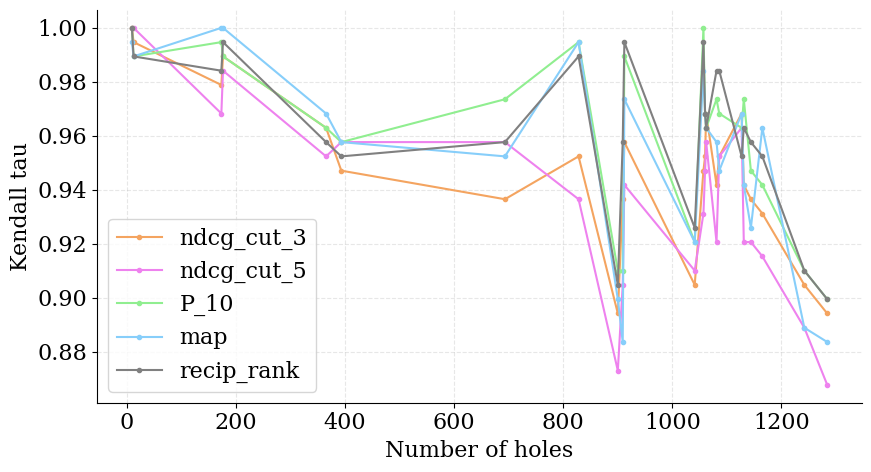

In [68]:
import matplotlib.pyplot as plt
import matplotlib
import collections

dict_hole_metrics =  collections.OrderedDict(sorted(dict_hole_metrics.items()))
font = {'family' : 'serif',
        'size':16}
matplotlib.rc('font', **font)

plt.figure(figsize=(9,5))
x = list(dict_hole_metrics.keys())

y = [dict_hole_metrics[key_1]['ndcg_cut_3'] for key_1 in dict_hole_metrics.keys() ]
plt.plot(x, y, '.-', color="sandybrown")

y = [dict_hole_metrics[key_1]['ndcg_cut_5'] for key_1 in dict_hole_metrics.keys() ]
plt.plot(x, y, '.-', color="violet")

y = [dict_hole_metrics[key_1]['P_10'] for key_1 in dict_hole_metrics.keys() ]
plt.plot(x, y, '.-', color="lightgreen")

y = [dict_hole_metrics[key_1]['map'] for key_1 in dict_hole_metrics.keys() ]
plt.plot(x, y, '.-', color="lightskyblue")

y = [dict_hole_metrics[key_1]['recip_rank'] for key_1 in dict_hole_metrics.keys() ]
plt.plot(x, y, '.-', color="grey")



plt.grid(True, linestyle='--', alpha=0.3)

ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

plt.legend(['ndcg_cut_3', 'ndcg_cut_5', 'P_10', 'map', 'recip_rank'])

plt.xlabel("Number of holes")
plt.ylabel("Kendall tau")
plt.tight_layout()
plt.savefig("hole_dist.pdf")
plt.show()

In [ ]:


metrics_to_eval = ['ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = 'trec_format/'  

pool_directory = 'tmp_pool_remove_one_run/'
all_models_names = list(os.listdir(pool_directory))
pool_directory = 'tmp_pool_remove_one_run/'

ranking_level_eval_with_name(all_models_names, directory_name, metrics_to_eval, pool_directory)   


In [ ]:


metrics_to_eval = ['ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = 'trec_format/'  

models_main_name = {
                    'gpt3.5-one-shot-pool-V2': 'one-shot',
                    'gpt3.5-one-shot-pool-V2-temp0': 'one-shot (tmp=0)',
                    'gpt3.5-two-shot-pool' : 'two-shot',
                    'gpt3.5-two-shot-pool-V2-temp0': 'two-shot (tmp=0)',
                    'gpt3.5-zero-shot-pool':'zero-shot',
                    'gpt3.5-zero-shot-paul-pool-temp0-': 'zero-shot (tmp=0)',
                    'Llama-3-FT-pool': 'Llama-3 FT',
                    'Llama-3-inst-FT-pool': 'Llama-3-inst FT',
                    'Llama-3-zero-pool': 'Llama-3 zero-shot',
                    'Llama-3-inst-zero-pool': 'Llama-3-inst zero-shot'
                    }

all_models_names = list(models_main_name.keys())

pool_directory = 'tmp_pools/'

ranking_level_eval(all_models_names, directory_name, metrics_to_eval, pool_directory)

   

In [ ]:


metrics_to_eval = ['ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = 'trec_format/'  
models_main_name = {'gpt3.5-one-shot-pool-V2': 'one-shot',
                    'gpt3.5-one-shot-pool-V2-temp0': 'one-shot (tmp=0)',
                    'gpt3.5-two-shot-pool' : 'two-shot',
                    'gpt3.5-two-shot-pool-V2-temp0': 'two-shot (tmp=0)',
                    'gpt3.5-zero-shot-pool':'zero-shot',
                    'gpt3.5-zero-shot-paul-pool-temp0-': 'zero-shot (tmp=0)'
                    }

all_models_names = list(models_main_name.keys())
pool_directory = 'outputs/'

ranking_level_eval(all_models_names, directory_name, metrics_to_eval, pool_directory) 
  

In [ ]:
metrics_to_eval = ['ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = 'trec_format/'

pool_path = 'outputs/gpt3.5-one-shot-pool-V2.txt'
pool_path_2 = 'pools/human_qrels'

lines_spearman, lines_kendall, lines_rbo = ranking_level_eval_one_model(pool_path, pool_path_2, directory_name, metrics_to_eval)

print('\n\nRBO: *******************\n\n')  
for line in lines_rbo:
    print(line)

print('\n\nSpearman: *******************\n\n')    

for line in lines_spearman:
    print(line)

print('\n\nKendall:  *******************\n\n') 

for line in lines_kendall:
    print(line)



In [36]:

from collections import defaultdict

def ranking_level_eval_figure(pool_path, pool_path_2, directory_name, metrics_to_eval):

    results_per_model_1 = eval_all_models_given_pool(pool_path, directory_name, metrics_to_eval)
    results_per_model_2 = eval_all_models_given_pool(pool_path_2, directory_name, metrics_to_eval)

    result_per_metric = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    
    for metric in metrics_to_eval:

        sorted_list_1 = return_sorted_list_of_runs(results_per_model_1, metric)
        sorted_list_2 = return_sorted_list_of_runs(results_per_model_2, metric)
        # x_labels = [i for i in range(2, len(sorted_list_1)+1)]

        for k_ in range(2, len(sorted_list_1)+1):
            k, s, rbo_ = compare_two_lists_at_k(sorted_list_1, sorted_list_2, k_)
            result_per_metric[metric]['K'][k_] = round(k, 3)
            result_per_metric[metric]['S'][k_] = round(s, 3)
            result_per_metric[metric]['RBO'][k_] = round(rbo_, 3)

    return result_per_metric
  

metrics_to_eval = ['ndcg_cut_3','ndcg_cut_5','ndcg', 'P_10', 'recall_10', 'recall_1000', 'map', 'recip_rank']
directory_name = 'trec_format/'

pool_path = 'outputs/gpt3.5-one-shot-pool-V2.txt'
pool_path_2 = 'pools/human_qrels'


result_per_metric = ranking_level_eval_figure(pool_path, pool_path_2, directory_name, metrics_to_eval)

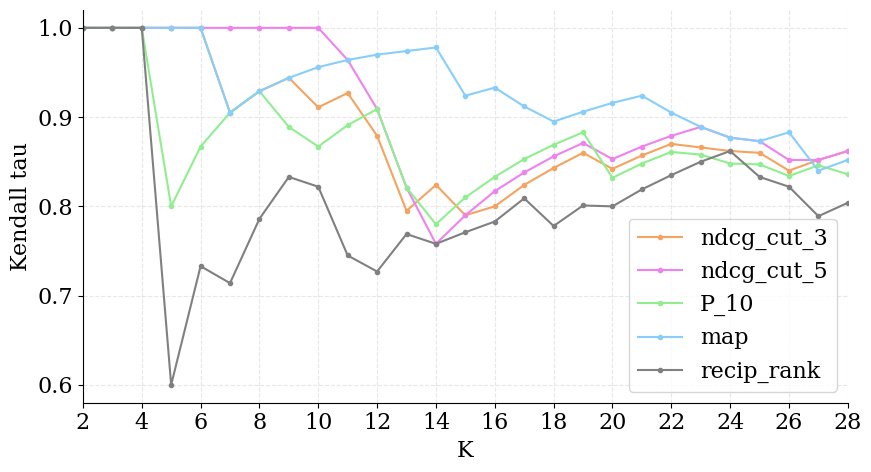

In [99]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'serif',
        'size':16}
matplotlib.rc('font', **font)

plt.figure(figsize=(9,5))

plt.plot(result_per_metric['ndcg_cut_3']['K'].keys(), result_per_metric['ndcg_cut_3']['K'].values(), '.-', color="sandybrown")
plt.plot(result_per_metric['ndcg_cut_5']['K'].keys(), result_per_metric['ndcg_cut_5']['K'].values(), '.-', color="violet")
plt.plot(result_per_metric['P_10']['K'].keys(), result_per_metric['P_10']['K'].values(), '.-', color="lightgreen")
plt.plot(result_per_metric['map']['K'].keys(), result_per_metric['map']['K'].values(), '.-', color="lightskyblue")
plt.plot(result_per_metric['recip_rank']['K'].keys(), result_per_metric['recip_rank']['K'].values(), '.-', color="grey")

plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(range(2, len(result_per_metric['ndcg']['K'].keys())+2, 2))
plt.xlim([2, 28])
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

plt.legend(['ndcg_cut_3', 'ndcg_cut_5', 'P_10', 'map', 'recip_rank'])

plt.xlabel("K")
plt.ylabel("Kendall tau")
plt.tight_layout
plt.savefig("kendall@k.pdf")
plt.show()